In [ ]:
# !wget -nc https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip
# # if the link does not work, you can download the dataset manually from https://disk.yandex.ru/d/nuyCNaDrE1Bq0w
# !unzip -n data.zip

In [ ]:
import requests
import torch
from torch import nn
import os
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
# model.train(False);
model.train();

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model.fc = nn.Linear(model.fc.in_features, 2, bias=True)
model.to(device)

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
params = []
for param in model.parameters():
    if param.requires_grad:
        params.append(param)

In [ ]:
optimizer = torch.optim.Adam(params, lr=1e-6)

criterion = nn.CrossEntropyLoss()

N_EPOCH = 10
batch_size = 32

## Create dataloater

In [ ]:
from torch.utils.data import Dataset 
from torchvision import transforms
class PathDataset(Dataset):
    """
    This class inherits from pytorch dataset.
    It defines, how the data will be downloaded and preprocessed.
    """
    
    def __init__(self, data_paths, transform_X=None):
        self.data_paths = data_paths
        self.transform_X = transform_X
    
    def __getitem__(self, index):
        x = Image.open(self.data_paths[index])
        if self.transform_X:
            x = self.transform_X(x)
        y = "cat" in self.data_paths[index]
        return x.to(device), torch.tensor(y).float().to(device)

    def __len__(self):
        return len(self.data_paths)

In [ ]:
# Define path to folder with images
train_paths = ["./train/" + name for name in os.listdir("train/")]

print(len(train_paths))
# Here I split val/train half and half
# val_paths = train_paths[:12500]
# train_paths = train_paths[12500:22500]

val_paths = train_paths[:1250]
train_paths = train_paths[1250:2250]

len(val_paths), len(train_paths), np.sum(["cat" in path for path in val_paths]),\
                                  np.sum(["cat" in path for path in train_paths])

In [ ]:
# ImageNet mean and std based on millions of images
means = np.array((0.485, 0.456, 0.406))
stds = np.array((0.229, 0.224, 0.225))

transform_X = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [ ]:
train_ds = PathDataset(train_paths, transform_X=transform_X)
val_ds = PathDataset(val_paths, transform_X=transform_X)

trainloader = torch.utils.data.DataLoader(train_ds, 
                                              batch_size=batch_size,
                                              shuffle=True)
testloader = torch.utils.data.DataLoader(val_ds, 
                                            batch_size=batch_size,
                                            shuffle=False)

In [ ]:
from tqdm.notebook import tqdm
from torch.utils.data import Dataset 
from PIL import Image

In [ ]:
def train(model, optimizer, loader, criterion):
    model.train()
    losses_tr = []
    for images, targets in tqdm(loader):
        images = images.to(device)
        targets = targets.to(device)
        targets = targets.type(torch.LongTensor)
        
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, targets)
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item()) 
    
    return model, optimizer, np.mean(losses_tr)

In [ ]:
def val(model, loader, criterion, metric_names=None):
    model.eval()
    losses_val = []
    if metric_names:
        metrics = {name: [] for name in metric_names}
    with torch.no_grad():
        for images, targets in tqdm(loader):
            images = images.to(device)
            targets = targets.to(device)
            targets = targets.type(torch.LongTensor)
            
            out = model(images)
            loss = criterion(out, targets)
            losses_val.append(loss.item())
            
            if metric_names:
                if 'accuracy' in metrics:
                    _, pred_classes = torch.max(out, dim=-1)
                    metrics['accuracy'].append((pred_classes == targets).float().mean().item())
                if 'top2accuracy' in metrics:
                    preds = torch.argsort(out, dim=1, descending=True)
                    metrics['top2accuracy'].append(
                        np.mean([targets[i] in preds[i, :2] for i in range(len(targets))])
                    )
                if 'top3accuracy' in metrics:
                    preds = torch.argsort(out, dim=1, descending=True)
                    metrics['top3accuracy'].append(
                        np.mean([targets[i] in preds[i, :3] for i in range(len(targets))])
                    )
    
        if metric_names:
            for name in metrics:
                metrics[name] = np.mean(metrics[name])
    
    return np.mean(losses_val), metrics if metric_names else None

In [ ]:
def learning_loop(model, optimizer, train_loader, val_loader, criterion, scheduler=None, min_lr=None, epochs=2, val_every=1, draw_every=1, metric_names=None):
    losses = {'train': [], 'val': []}
    if metric_names:
        metrics = {name: [] for name in metric_names}

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss, metrics_ = val(model, val_loader, criterion, metric_names)
            losses['val'].append(loss)
            if metric_names:
                for name in metrics_:
                    metrics[name].append(metrics_[name])
            if scheduler:
                scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            ww = 2 if metric_names else 1
            fig, ax = plt.subplots(1, ww, figsize=(20, 10))
            fig.suptitle(f'#{epoch}/{epochs}:')

            plt.subplot(1, ww, 1)
            plt.title('losses')
            plt.plot(losses['train'], 'r.-', label='train')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            if metric_names:
                plt.subplot(1, ww, 2)
                plt.title('additional metrics')
                for name in metric_names:
                    plt.plot(metrics[name], '.-', label=name)
                plt.legend()
            
            plt.show()
        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses, metrics if metric_names else None

In [ ]:
model, optimizer, losses, metrics = learning_loop(model, optimizer, trainloader, 
                                                  testloader, criterion, epochs=N_EPOCH, 
                                                  metric_names={'accuracy'})

Result
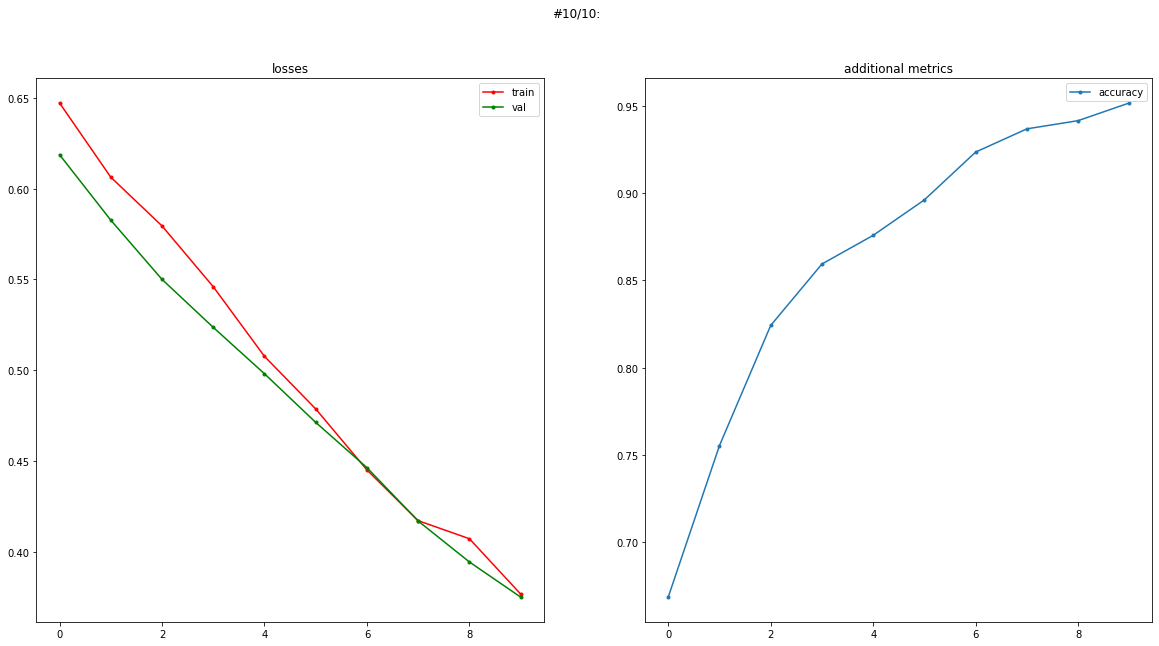

In [ ]:
loss, metrics_ = val(model, testloader, criterion, metric_names={'accuracy'})